# Tutorial-1

The first thing to do to use the python wrappers is to import the package. **PyDealII** is only a shell and importing it will only allow you to call
```python 
help(PyDealII)
``` 
**PyDealII** is composed of two libraries: 
 - **PyDealII.Debug** which uses the debug version of **deal.II**
 - **PyDealII.Release** which uses the release version of **deal.II**
 
In this tutorial, we import the debug version of the library as **dealii**.

In [1]:
%matplotlib inline
import PyDealII.Debug as dealii

We start by creating a 2D **Triangulation** of an hyper cube and we globally refine it twice. You can read the documentation of **Triangulation** by typing:
```python
help(dealii.Triangulation)
```
This will show you all the functions associated with **Triangulation** and for each one, you will get a short explanation.

In [2]:
triangulation = dealii.Triangulation('2D')
triangulation.generate_hyper_cube()
triangulation.refine_global(2)

Now we would like to visualize the mesh that has been created. We can output a _vtu_ file using
```python
triangulation.write('triangulation.vtu', 'vtu')
```
and then use VisIt or Paraview. This is probably what you want to do for a 3D **Triangulation**. However, in this tutorial, we will create a function to plot the result using matplotlib. This will allow us to look at the mesh inside the notebook. To do that we will use _matplotlib_ and _numpy_.

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np

The function below takes as input a **Triangulation** and a function that is used to define the color scheme. In this function, we loop over all the active cells, get the coordinates of the vertices, and use these coordinates to create polygons that we plot. We can loop over the active cells using
```python
for cell in triangulation.active_cells()
```
Once we have a cell, we can get any vertex using
```python
vertex = cell.get_vertex(i)
```
Since a _vertex_ is a **Point**, we can the coordinates of the **Point** using
```python
x = vertex.x
y = vertex.y
z = vertex.z
```


In [4]:
def plot_triangulation(triangulation, color_scheme):
    fig, ax = plt.subplots()
    patches = []
    colors = []
    cell_id = 0 
    for cell in triangulation.active_cells():
        quad_vertices = np.zeros((4,2))
        # The shift variable is used to reorder the vertices because
        # deal.II and matplotlib require different ordering
        shift = [0,1,3,2]
        for i in range(4):
            vertex = cell.get_vertex(i)
            quad_vertices[shift[i]][0] = vertex.x
            quad_vertices[shift[i]][1] = vertex.y
        quad = Polygon(quad_vertices, closed=True)
        patches.append(quad)
        colors.append(color_scheme(cell_id, cell))
        cell_id += 1
    p = PatchCollection(patches)  
    p.set_array(np.array(colors))
    ax.add_collection(p, autolim=True)
    ax.autoscale_view()
    plt.show()

We know define a color scheme function and plot the **Triangulation**

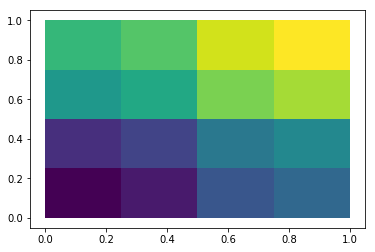

In [5]:
def color_sc(cell_id, cell):
    return cell_id

plot_triangulation(triangulation, color_sc)

Now let's assume that the left half of the domain is composed of a different material than the right half of the domain. We will loop over all the cells and if the abscissa of the cell barycenter is less than 0.5, we will assign zero to the *material_id* of the cell. The others cells will be assigned a *material_id* of one.


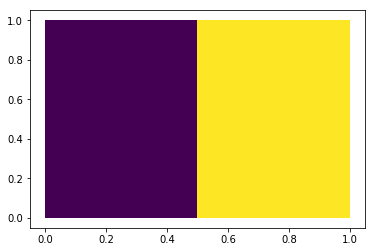

In [6]:
for cell in triangulation.active_cells():
    if cell.barycenter().x < 0.5:
        cell.material_id = 0
    else:
        cell.material_id = 1

plot_triangulation(triangulation, lambda cell_id,cell :  cell.material_id)

We will refine isotropically the cells that have a *material_id* equal to zero and plot the **Triangulation**.

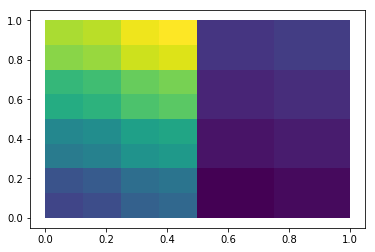

In [7]:
for cell in triangulation.active_cells():
    if cell.material_id == 0:
        cell.refine_flag ='isotropic'
triangulation.execute_coarsening_and_refinement()

plot_triangulation(triangulation, color_sc)

We will now show how to merge two **Triangulations**. In order to merge the two **Triangulations**, we will need to move (shift) the second **Triangulation** such that it doesn't overlap with the first one.

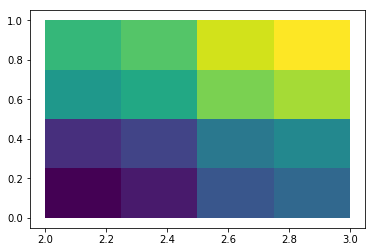

In [8]:
triangulation_2 = dealii.Triangulation('2D')
triangulation_2.generate_hyper_cube()
triangulation_2.refine_global(2)
triangulation_2.shift([2.,0.])

plot_triangulation(triangulation_2, color_sc)

We are now almost ready to merge the **Triangulations**. However, deal.II does not allow us to merge **Triangulations** that have been refined. We can use the *flatten_triangulation* function to create new **Triangulations** that are not refined but this function does not work if the mesh contains hanging nodes. Thus, we need to modify the first triangulation.

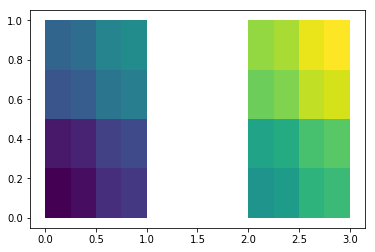

In [9]:
flatten_triangulation_1 = dealii.Triangulation('2D')
triangulation.generate_hyper_cube()
triangulation.refine_global(2)
triangulation.flatten_triangulation(flatten_triangulation_1)
flatten_triangulation_2 = dealii.Triangulation('2D')
triangulation_2.flatten_triangulation(flatten_triangulation_2)
triangulation_3 = dealii.Triangulation('2D')
triangulation_3.merge_triangulations([flatten_triangulation_1, flatten_triangulation_2])

plot_triangulation(triangulation_3, color_sc)

Like expected the second **Triangulation** is moved too far on the right. This mistake can easily fixed by moving *flatten_triangulation_2* to the left and merging the **Triangulations** once again. We can see the advantage of using python over C++. In C++, we would have to recompile and rerun the code while in python we can very easily fix our mistake.

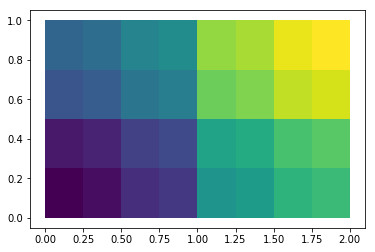

In [10]:
flatten_triangulation_2.shift([-1.,0])
triangulation_3.merge_triangulations(flatten_triangulation_1, flatten_triangulation_2)

plot_triangulation(triangulation_3, color_sc)

Now that we are done generating the grid, we need to save it in a format that will make it easy to load in our C++ code. This can  be done using the _save_ function python and then using the _Triangulation::load()_ function in C++. The only caveat is that **parallel::distributed::Triangulation** cannot load a grid which has refined cells. Once again this can be fixed by flattening the **Triangulation** (this is not necessary here).

In [11]:
triangulation_3.save('merged_triangulation')

The C++ code to load the mesh is
```C++
triangulation.load('merged_triangulation');
```

**NOTE**
If the C++ code throws an exception, the error message will be shown. However, if the code segfaults then the kernel will simply be killed. In this case, the easiest way to debug your code is to use gdb to find the problem. This can be done by exporting your notebook as a python code and then typing:
``` bash
gdb python
run my_program.py
```
Below, we show an example of an error message coming from the C++ code.

In [12]:
for cell in triangulation.active_cells():
    vertex = cell.get_vertex(5)

RuntimeError: 
--------------------------------------------------------
An error occurred in line <443> of file </home/jovyan/work/dealii/contrib/python-bindings/source/cell_accessor_wrapper.cc> in function
    dealii::python::PointWrapper dealii::python::CellAccessorWrapper::get_vertex(int) const
The violated condition was: 
    i<std::pow(2,dim)
Additional information: 
    Requested vertex number 5 does not exist. The largest vertex number acceptable is 3
--------------------------------------------------------
